In [33]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from patsy import dmatrix
import ast 

from statsmodels.nonparametric.smoothers_lowess import lowess
import statsmodels.formula.api as smf

___
LOAD DATASETS
___

In [ ]:
monthly_openai_embed_path = "../../data/proc/embeddings/monthly_openai_emb_wide.csv"
daily_openai_embed_path = "../../data/proc/embeddings/daily_openai_emb_long.csv"
daily_labelled_wide = "../../data/proc/labelled_daily_goals_wide.csv"

In [39]:
monthly_cols = [
    "ParticipantIdentifier",
    "trial_date",
    "MONTHLY_goal_set1",
    "MONTHLY_goal_set2",
    "monthly_emb1",
    "monthly_emb2"
]

monthly_emb = pd.read_csv(monthly_openai_embed_path)[monthly_cols]

In [40]:
daily_emb = pd.read_csv(daily_openai_embed_path)

In [41]:
daily_labelled = pd.read_csv(daily_labelled_wide)

In [5]:
df_emb_wide = daily_emb.pivot_table(
    index=['ParticipantIdentifier', 'trial_date'],
    columns='ResultIdentifier',
    values='emb',
    aggfunc='first'
).reset_index(drop=False)

In [42]:
monthly_emb["trial_date"] = pd.to_datetime(monthly_emb["trial_date"])
monthly_emb = monthly_emb.sort_values(["ParticipantIdentifier", "trial_date"]).reset_index(drop=True)

df_emb_wide["trial_date"] = pd.to_datetime(df_emb_wide["trial_date"])
df_emb_wide = df_emb_wide.sort_values(["ParticipantIdentifier", "trial_date"]).reset_index(drop=True)

daily_labelled["trial_date"] = pd.to_datetime(daily_labelled["trial_date"])
daily_labelled = daily_labelled.sort_values(["ParticipantIdentifier", "trial_date"]).reset_index(drop=True)

In [45]:
print("Number of columns in daily labelled dataset is: ", len(daily_labelled))
print("Number of columns in daily embedding dataset is: ", len(df_emb_wide))
print("Number of columns in monthly dataset is:", len(monthly_emb))

Number of columns in daily labelled dataset is:  7788
Number of columns in daily embedding dataset is:  7401
Number of columns in monthly dataset is: 466


___
PUT IN MONTH NUMBER IN DAILY DATASET FOR DOWNSTREAM FILTERING AND MERGING
___

In [46]:
def get_participant_month_label(pid, date, monthly_emb,
                                pid_col="ParticipantIdentifier",
                                date_col="trial_date",
                                label_col="month_number"):
    """
    Return the 'label_col' of the first row whose date is AFTER 'date',
    but only if 'date' is strictly between the previous and current row's dates.

    Example logic: if rows[i-1].date < date < rows[i].date → return rows[i].label
    """
    # Filter to this participant and ensure chronological order
    rows = (monthly_emb.loc[monthly_emb[pid_col] == pid]
                        .sort_values(date_col)
                        .reset_index(drop=True))
    # Walk adjacent pairs
    for i in range(1, len(rows)):
        prev_date = rows.iloc[i - 1][date_col]
        curr_date = rows.iloc[i][date_col]
        if prev_date < date < curr_date:
            return rows.iloc[i - 1][label_col]
        
        if i == 2 and date > curr_date:
            return rows.iloc[i][label_col]

    return None

In [47]:
monthly_emb["month_number"] = (
    monthly_emb.groupby("ParticipantIdentifier").cumcount().add(1)
)

In [48]:
df_emb_wide["month_number"] = df_emb_wide.apply(lambda x: get_participant_month_label(
    x["ParticipantIdentifier"], x["trial_date"], monthly_emb,
    pid_col="ParticipantIdentifier",
    date_col="trial_date",
    label_col="month_number"), axis=1
)

df_emb_wide = df_emb_wide.dropna()

In [49]:
print("Number of columns in daily dataset is: ", len(df_emb_wide))
print("Number of columns in monthly dataset is:", len(monthly_emb))

Number of columns in daily dataset is:  7401
Number of columns in monthly dataset is: 466


___
SEE IF WE HAVE ENTRIES FOR EACH OF THE THREE MONTHS
___

In [50]:
df_emb_wide["month_number"].value_counts()

month_number
1    2896
2    2562
3    1943
Name: count, dtype: int64

___
SEE THE AVERAGE NUMBER OF ENTRIES PER MONTH FOR PARTICIPANTS. 
- Based on this, we will keep x number of rows for each participant for each month to make alignment across participants possible
___

In [51]:
# For each participant, will keep first 25 entries in first month
# For each participant, will keep first 20 entries in second month
# For each participant, will keep first 15 entries in third month

In [52]:
pid_col   = "ParticipantIdentifier"
month_col = "month_number"

# Ensure month_number is numeric (handles 1.0 → 1)
df = df_emb_wide.copy()
df[month_col] = pd.to_numeric(df[month_col], errors="coerce").astype("Int64")

# Keep only month 1, then count rows per participant
month1_counts = (
    df.loc[df[month_col].eq(1)]
      .groupby(pid_col)
      .size()
)

month2_counts = (
    df.loc[df[month_col].eq(2)]
      .groupby(pid_col)
      .size()
)

month3_counts = (
    df.loc[df[month_col].eq(3)]
      .groupby(pid_col)
      .size()
)

In [53]:
pid_col   = "ParticipantIdentifier"
month_col = "month_number"

# count entries per participant per month
per_pid_month = (
    df.groupby([pid_col, month_col], dropna=False)
               .size()
               .rename("entries")
               .reset_index()
)

# average across participants for each month_number
avg_per_month = (
    per_pid_month.groupby(month_col)["entries"]
                 .mean()
                 .rename("avg_entries_per_participant")
                 .reset_index()
)

count_per_month = (
    per_pid_month.groupby(month_col)["entries"]
                 .count()
                 .rename("count_of_participants")
                 .reset_index()
)

print(avg_per_month)
print(count_per_month)

   month_number  avg_entries_per_participant
0             1                    25.857143
1             2                    24.873786
2             3                    18.864078
   month_number  count_of_participants
0             1                    112
1             2                    103
2             3                    103


In [88]:
# IDs with at least 25 entries
participant_ids_m1plus = month1_counts[month1_counts >= 15].index.tolist()
participant_ids_m2plus = month2_counts[month2_counts >= 15].index.tolist()
participant_ids_m3plus = month3_counts[month3_counts >= 15].index.tolist()


# print(f"{len(participant_ids_25plus)} participants meet the criterion.")
# print(f"{len(participant_ids_20plus)} participants meet the criterion.")
# print(f"{len(participant_ids_15plus)} participants meet the criterion.")

In [90]:
eligible_ids = list(
    set(participant_ids_m1plus)
    & set(participant_ids_m2plus)
    & set(participant_ids_m3plus)
)

print(len(eligible_ids))

76


___

In [70]:
merged = df.merge(monthly_emb, on = ['ParticipantIdentifier', 'month_number'], how='outer')

In [71]:
merged = merged.rename(columns={
    "trial_date_x": "trial_date",
    "trial_date_y": "monthly_goal_set_date",
    "MONTHLY_goal_set1": "MONTHLY_goal_1",
    "MONTHLY_goal_set2": "MONTHLY_goal_2",
    "DAILY_goal1_set": "daily_emb1",
    "DAILY_goal2_set": "daily_emb2"
})

merged = merged.merge(daily_labelled, on = ['ParticipantIdentifier', 'trial_date'], how='inner')
merged = merged.rename(columns={
    "DAILY_goal1_set": "daily_goal_1",
    "DAILY_goal2_set": "daily_goal_2"
})

In [73]:
cols = ["daily_emb1", "daily_emb2", "monthly_emb1", "monthly_emb2"]

for c in cols:
    merged[c] = merged[c].apply(lambda x: ast.literal_eval(x) if isinstance(x, str) else x)
    
merged = merged.dropna()
merged.head(3)

,ParticipantIdentifier,trial_date,daily_emb1,daily_emb2,month_number,monthly_goal_set_date,MONTHLY_goal_1,MONTHLY_goal_2,monthly_emb1,monthly_emb2,daily_goal_1,daily_goal_2,DAILY_goal1_label,DAILY_goal2_label
0,0151d9f1-1644-4437-805e-02f5e244a690,2023-02-01,"[-0.002160745905712247, 0.0015396077651530504,...","[-0.04656229913234711, 0.0007934867171570659, ...",1,2023-01-30,"Maintain a healthy sleep schedule, workout rou...",Catch up on assignments,"[0.013699877075850964, 0.029950568452477455, -...","[-0.021843016147613525, 0.036371320486068726, ...",Keep working on psych paper,Finish chem prelab,School,School
1,0151d9f1-1644-4437-805e-02f5e244a690,2023-02-02,"[-0.002160745905712247, 0.0015396077651530504,...","[-0.014762434177100658, 0.02009924314916134, -...",1,2023-01-30,"Maintain a healthy sleep schedule, workout rou...",Catch up on assignments,"[0.013699877075850964, 0.029950568452477455, -...","[-0.021843016147613525, 0.036371320486068726, ...",Keep working on psych paper,Review bio questions,School,School
2,0151d9f1-1644-4437-805e-02f5e244a690,2023-02-03,"[-0.03221265226602554, -0.010712618008255959, ...","[0.007794945500791073, 0.014498291537165642, -...",1,2023-01-30,"Maintain a healthy sleep schedule, workout rou...",Catch up on assignments,"[0.013699877075850964, 0.029950568452477455, -...","[-0.021843016147613525, 0.036371320486068726, ...",Finish and hand in psych rough draft,Create quick bio lecture notes,School,School


In [79]:
def cosine(u, v):
    # print(u, v)
    u = np.asarray(u, dtype=float)
    v = np.asarray(v, dtype=float)
    nu = np.linalg.norm(u); nv = np.linalg.norm(v)
    if nu == 0 or nv == 0: 
        return np.nan
    return float(np.dot(u, v) / (nu * nv))

def get_max_similarity(row):
    sims = {
        ("daily_emb1", "monthly_emb1"): cosine(row["daily_emb1"], row["monthly_emb1"]),
        ("daily_emb1", "monthly_emb2"): cosine(row["daily_emb1"], row["monthly_emb2"]),
        ("daily_emb2", "monthly_emb1"): cosine(row["daily_emb2"], row["monthly_emb1"]),
        ("daily_emb2", "monthly_emb2"): cosine(row["daily_emb2"], row["monthly_emb2"]),
    }

    # find max pair
    (daily, monthly), max_sim = max(sims.items(), key=lambda x: x[1])

    return pd.Series({
        "max_similarity": max_sim,
        "chosen_daily": daily,
        "chosen_monthly": monthly,
    })

In [80]:
merged[["daily_monthly_sim", "chosen_daily", "chosen_monthly"]] = merged.apply(lambda x: get_max_similarity(x), axis=1)

In [82]:
ord_cols = [
    "ParticipantIdentifier",
    "trial_date", 
    "monthly_goal_set_date", 
    "month_number",
    "daily_goal_1", "daily_goal_2",
    "MONTHLY_goal_1", "MONTHLY_goal_2",			
    "DAILY_goal1_label", "DAILY_goal2_label",
    "daily_monthly_sim", "chosen_daily", "chosen_monthly"
]

merged = merged[ord_cols]

In [83]:
merged["day_since_month_start"] = (merged["trial_date"] - merged["monthly_goal_set_date"]).dt.days
merged.head(5)

,ParticipantIdentifier,trial_date,monthly_goal_set_date,month_number,daily_goal_1,daily_goal_2,MONTHLY_goal_1,MONTHLY_goal_2,DAILY_goal1_label,DAILY_goal2_label,daily_monthly_sim,chosen_daily,chosen_monthly,day_since_month_start
0,0151d9f1-1644-4437-805e-02f5e244a690,2023-02-01,2023-01-30,1,Keep working on psych paper,Finish chem prelab,"Maintain a healthy sleep schedule, workout rou...",Catch up on assignments,School,School,0.442575,daily_emb2,monthly_emb2,2
1,0151d9f1-1644-4437-805e-02f5e244a690,2023-02-02,2023-01-30,1,Keep working on psych paper,Review bio questions,"Maintain a healthy sleep schedule, workout rou...",Catch up on assignments,School,School,0.424231,daily_emb1,monthly_emb2,3
2,0151d9f1-1644-4437-805e-02f5e244a690,2023-02-03,2023-01-30,1,Finish and hand in psych rough draft,Create quick bio lecture notes,"Maintain a healthy sleep schedule, workout rou...",Catch up on assignments,School,School,0.445251,daily_emb1,monthly_emb2,4
3,0151d9f1-1644-4437-805e-02f5e244a690,2023-02-04,2023-01-30,1,Practice biology FSG questions,Catch up on anthropology readings,"Maintain a healthy sleep schedule, workout rou...",Catch up on assignments,School,School,0.572936,daily_emb2,monthly_emb2,5
4,0151d9f1-1644-4437-805e-02f5e244a690,2023-02-05,2023-01-30,1,Practice biology FSG questions,Continue reading anthropology,"Maintain a healthy sleep schedule, workout rou...",Catch up on assignments,School,Reading_leisure,0.248102,daily_emb1,monthly_emb2,6


In [91]:
unfiltered_df = merged.copy()
count_filter_df = merged.groupby("ParticipantIdentifier").filter(lambda x: len(x) >= 40)
count_month_filter_df = merged.loc[merged["ParticipantIdentifier"].isin(eligible_ids)]

In [92]:
# df1 = df.loc[df["month_number"] == 1].copy()
model = smf.mixedlm(
    "daily_monthly_sim ~ day_since_month_start",
    data=unfiltered_df,
    groups=unfiltered_df["ParticipantIdentifier"],
    # re_formula="~prev_day_completion_max*day_sim_max"  # random slopes too
).fit()

print(model.summary())

model = smf.mixedlm(
    "daily_monthly_sim ~ day_since_month_start",
    data=count_filter_df,
    groups=count_filter_df["ParticipantIdentifier"],
    # re_formula="~prev_day_completion_max*day_sim_max"  # random slopes too
).fit()

print(model.summary())

model = smf.mixedlm(
    "daily_monthly_sim ~ day_since_month_start",
    data=count_month_filter_df,
    groups=count_month_filter_df["ParticipantIdentifier"],
    # re_formula="~prev_day_completion_max*day_sim_max"  # random slopes too
).fit()

print(model.summary())

             Mixed Linear Model Regression Results
Model:             MixedLM Dependent Variable: daily_monthly_sim
No. Observations:  7396    Method:             REML             
No. Groups:        112     Scale:              0.0238           
Min. group size:   19      Log-Likelihood:     3109.7001        
Max. group size:   81      Converged:          Yes              
Mean group size:   66.0                                         
----------------------------------------------------------------
                      Coef.  Std.Err.   z    P>|z| [0.025 0.975]
----------------------------------------------------------------
Intercept              0.447    0.012 35.903 0.000  0.423  0.472
day_since_month_start -0.001    0.000 -5.562 0.000 -0.002 -0.001
Group Var              0.016    0.014                           

             Mixed Linear Model Regression Results
Model:             MixedLM Dependent Variable: daily_monthly_sim
No. Observations:  7170    Method:             REML 

In [93]:
merged[["ParticipantIdentifier",
    "trial_date", 
    "monthly_goal_set_date", 
    "month_number",
    "daily_goal_1", "daily_goal_2",
    "MONTHLY_goal_1", "MONTHLY_goal_2",			
    "DAILY_goal1_label", "DAILY_goal2_label",
    "daily_monthly_sim", "chosen_daily", "chosen_monthly"]].head()

,ParticipantIdentifier,trial_date,monthly_goal_set_date,month_number,daily_goal_1,daily_goal_2,MONTHLY_goal_1,MONTHLY_goal_2,DAILY_goal1_label,DAILY_goal2_label,daily_monthly_sim,chosen_daily,chosen_monthly
0,0151d9f1-1644-4437-805e-02f5e244a690,2023-02-01,2023-01-30,1,Keep working on psych paper,Finish chem prelab,"Maintain a healthy sleep schedule, workout rou...",Catch up on assignments,School,School,0.442575,daily_emb2,monthly_emb2
1,0151d9f1-1644-4437-805e-02f5e244a690,2023-02-02,2023-01-30,1,Keep working on psych paper,Review bio questions,"Maintain a healthy sleep schedule, workout rou...",Catch up on assignments,School,School,0.424231,daily_emb1,monthly_emb2
2,0151d9f1-1644-4437-805e-02f5e244a690,2023-02-03,2023-01-30,1,Finish and hand in psych rough draft,Create quick bio lecture notes,"Maintain a healthy sleep schedule, workout rou...",Catch up on assignments,School,School,0.445251,daily_emb1,monthly_emb2
3,0151d9f1-1644-4437-805e-02f5e244a690,2023-02-04,2023-01-30,1,Practice biology FSG questions,Catch up on anthropology readings,"Maintain a healthy sleep schedule, workout rou...",Catch up on assignments,School,School,0.572936,daily_emb2,monthly_emb2
4,0151d9f1-1644-4437-805e-02f5e244a690,2023-02-05,2023-01-30,1,Practice biology FSG questions,Continue reading anthropology,"Maintain a healthy sleep schedule, workout rou...",Catch up on assignments,School,Reading_leisure,0.248102,daily_emb1,monthly_emb2


___
DRAW ACROSS PARTICIPANT PLOTS
___

In [94]:
count_filter_df.head(3)

,ParticipantIdentifier,trial_date,monthly_goal_set_date,month_number,daily_goal_1,daily_goal_2,MONTHLY_goal_1,MONTHLY_goal_2,DAILY_goal1_label,DAILY_goal2_label,daily_monthly_sim,chosen_daily,chosen_monthly,day_since_month_start
0,0151d9f1-1644-4437-805e-02f5e244a690,2023-02-01,2023-01-30,1,Keep working on psych paper,Finish chem prelab,"Maintain a healthy sleep schedule, workout rou...",Catch up on assignments,School,School,0.442575,daily_emb2,monthly_emb2,2
1,0151d9f1-1644-4437-805e-02f5e244a690,2023-02-02,2023-01-30,1,Keep working on psych paper,Review bio questions,"Maintain a healthy sleep schedule, workout rou...",Catch up on assignments,School,School,0.424231,daily_emb1,monthly_emb2,3
2,0151d9f1-1644-4437-805e-02f5e244a690,2023-02-03,2023-01-30,1,Finish and hand in psych rough draft,Create quick bio lecture notes,"Maintain a healthy sleep schedule, workout rou...",Catch up on assignments,School,School,0.445251,daily_emb1,monthly_emb2,4


In [108]:
day_stats_daily_monthly_sim = (
    unfiltered_df.dropna(subset=["month_number", "day_since_month_start", "daily_monthly_sim"])
      .groupby(["month_number", "day_since_month_start"])["daily_monthly_sim"]
      .agg(avg="mean", median="median", std="std", n="count")
      .reset_index()
)

In [109]:
day_stats_daily_monthly_sim.head()

,month_number,day_since_month_start,avg,median,std,n
0,1,1,0.448432,0.410947,0.202136,46
1,1,2,0.410253,0.395445,0.156161,101
2,1,3,0.411743,0.384210,0.169285,101
3,1,4,0.412481,0.384111,0.170958,105
4,1,5,0.412031,0.376055,0.184970,106


In [110]:
# group_daily_monthly_sim = day_stats_daily_monthly_sim.loc[day_stats_daily_monthly_sim["n"] > 50]

In [111]:
def draw_graph(g, ax):
    x = g["day_since_month_start"].to_numpy()
    y = g["avg"].to_numpy()

    sm = lowess(y, x, frac=0.3, it=1, return_sorted=True)  # it=1 makes it robust to outliers
    ax.plot(sm[:, 0], sm[:, 1], linewidth=1.8)
    return ax

In [112]:
span = 0.3  # like R's loess span; try 0.25–0.5

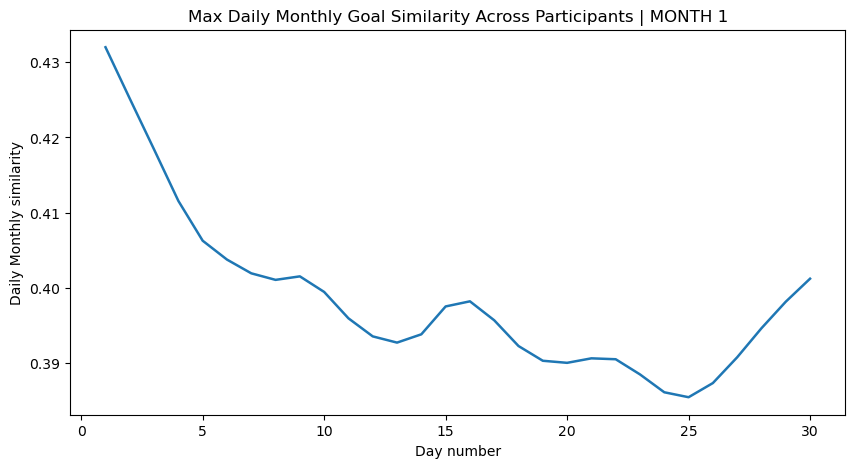

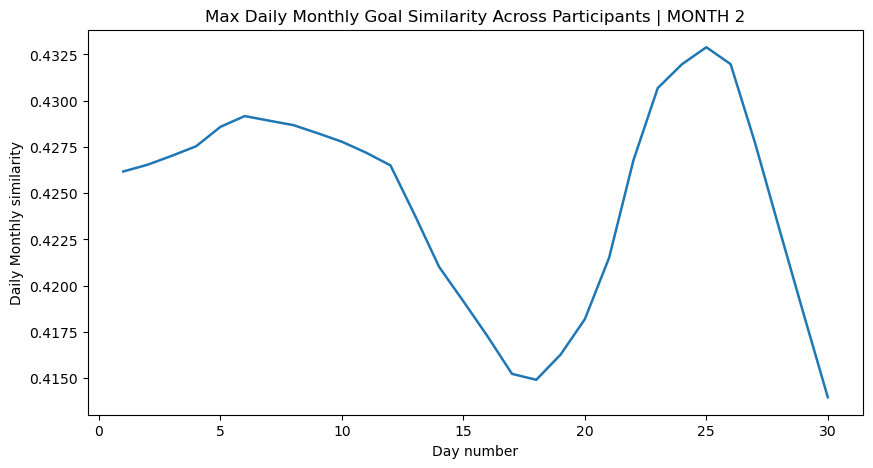

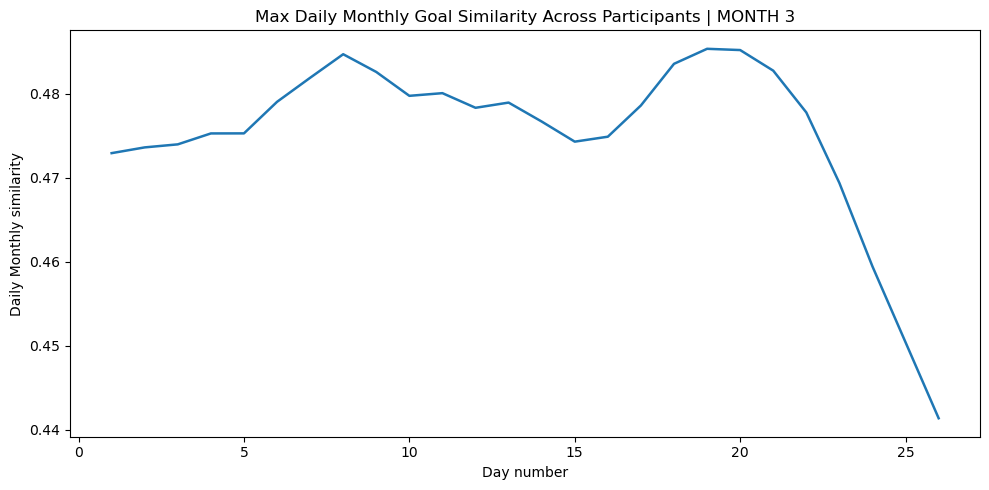

In [114]:
g = day_stats_daily_monthly_sim


fig, ax1 = plt.subplots(figsize=(10, 5))
fig, ax2 = plt.subplots(figsize=(10, 5))
fig, ax3 = plt.subplots(figsize=(10, 5))

draw_graph(g.loc[g['month_number'] == 1], ax1)
draw_graph(g.loc[g['month_number'] == 2], ax2)
draw_graph(g.loc[g['month_number'] == 3], ax3)

ax1.set_xlabel("Day number")
ax2.set_xlabel("Day number")
ax3.set_xlabel("Day number")

ax1.set_ylabel("Daily Monthly similarity")
ax2.set_ylabel("Daily Monthly similarity")
ax3.set_ylabel("Daily Monthly similarity")

ax1.set_title(f"Max Daily Monthly Goal Similarity Across Participants | MONTH 1")
ax2.set_title(f"Max Daily Monthly Goal Similarity Across Participants | MONTH 2")
ax3.set_title(f"Max Daily Monthly Goal Similarity Across Participants | MONTH 3")
plt.tight_layout()
plt.show()